# Short Term Risk Prediction With XGBoost

In this notebook we try and predict readmission in less than 30 days using data created in the Feature Engineering notebook.

In [1]:
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold, StratifiedKFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import os
import scikitplot as skplt
import time
import pickle

os.environ["OMP_NUM_THREADS"] = "8"

TRAIN = True

In [2]:
df = pd.read_csv("Clean_Data_v2.csv")

In [3]:
df.shape

(69879, 120)

In [4]:
df.head()

,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,...,admission_source_id_6,admission_source_id_7,admission_source_id_8,admission_source_id_9,admission_source_id_10,admission_source_id_11,admission_source_id_13,admission_source_id_14,admission_source_id_22,admission_source_id_25
0,0,1,41,0,1,0,0,0,1,NaN,...,0,0,0,0,0,0,0,0,0,0
1,10,3,59,0,18,0,0,0,9,NaN,...,0,1,0,0,0,0,0,0,0,0
2,20,2,11,5,13,2,0,1,6,NaN,...,0,1,0,0,0,0,0,0,0,0
3,30,2,44,1,16,0,0,0,7,NaN,...,0,1,0,0,0,0,0,0,0,0
4,40,1,51,0,8,0,0,0,5,NaN,...,0,1,0,0,0,0,0,0,0,0


# Train Test Split

In [5]:
X = df.drop(['readmitted','within30'],axis=1)
y = df['within30']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=5, stratify=y)

Examples in training:

In [6]:
y_train.value_counts()

0    46658
1     2257
Name: within30, dtype: int64

Examples in testing:

In [7]:
y_test.value_counts()

0    19997
1      967
Name: within30, dtype: int64

In both cases, the proportion of classes in the same.

In [8]:
scale_pos_weight = y_test.value_counts()[0] / y_test.value_counts()[1]
scale_pos_weight


20.6794208893485

This is our baseline for the scale_pos_weight parameter.

# Dealing With Class Imbalance

## Grid Search For Hyperparameters

Note that we are not using classification error for the evaluation metric because we would get "good" results from just choosing the negative class all the time. Instead, we use the auc curve so we need to perform well on the positive and negative cases.

Given that we are having issues with recall, we will change the scoring parameter to recall as opposed to ROC AUC as well.

In [10]:
model = XGBClassifier(n_jobs=8, scale_pos_weight=scale_pos_weight)
param_grid = {
    'max_depth': [3, 6, 8],
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.3, 0.1, 0.03],
    'min_child_weight': [1, 3, 5]
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)
grid_search = GridSearchCV(model, param_grid, scoring="recall", n_jobs=8, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.631361 using {'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100}


## Save the Model With The Best Hyperparameters

In [11]:
best_model = grid_result.best_estimator_
best_model


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20.6794208893485,
              seed=None, silent=None, subsample=1, verbosity=1)

## Tune Subsampling Parameters

XGBoost also has a lot of hyperparameters related to subsampling rows and columns when constructing trees. This can help generalizability. Ideally, we would have used variants of these in the grid search above but that would have required us to train exponentially more models. We don't think the subsampling parameters interact similar to learning rate, number of trees, and tree size do so we think we should be able to perform a grid search on the subsampling parameters with the other hyperparameters fixed to their optimums found above. We should end up with parameter settings similar to what would have been found if we had trained all possible permuations. We are trying to save computation by not training models with suboptimal settings for the parameters tested in the previous step.

In [24]:
model2 = XGBClassifier(n_jobs=8, learning_rate=0.03, max_depth=3, n_estimators=100, scale_pos_weight=scale_pos_weight, min_child_weight=5)
param_grid2 = {
    'colsample_bylevel': [0.5, 0.75, 1],
    'colsample_bynode': [0.5, 0.75, 1],
    'colsample_bytree': [0.5, 0.75, 1],
    'subsample': [0.5, 0.75, 1],
}

grid_search = GridSearchCV(model2, param_grid2, scoring="recall", n_jobs=8, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.632691 using {'colsample_bylevel': 0.75, 'colsample_bynode': 0.75, 'colsample_bytree': 0.75, 'subsample': 1}


## Train the Model With All Best Parameters

In [25]:
model2 = grid_result.best_estimator_
model2


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
              colsample_bynode=0.75, colsample_bytree=0.75, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=8,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20.6794208893485,
              seed=None, silent=None, subsample=1, verbosity=1)

## Accuracy

In [26]:
y_train_pred = model2.predict(X_train)
accuracy = accuracy_score(y_train, y_train_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 68.80%


In [27]:
# make predictions for test set
y_pred = model2.predict(X_test)
y_pred_proba = model2.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.79%


In [ ]:
y_pred

In [ ]:
np.sum(y_pred)

In [28]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  13806
False Positives:  6191
False Negatives:  351
True Positives:  616


In [29]:
def compute_precision(tp, fp):
    return tp / (tp + fp)

def compute_recall(tp, fn):
    return tp / (tp + fn)

precision = compute_precision(tp, fp)
recall = compute_recall(tp, fn)

print('Precision: {0:.2f}\n\nRecall: {1:.2f}'.format(precision, recall))

Precision: 0.09

Recall: 0.64


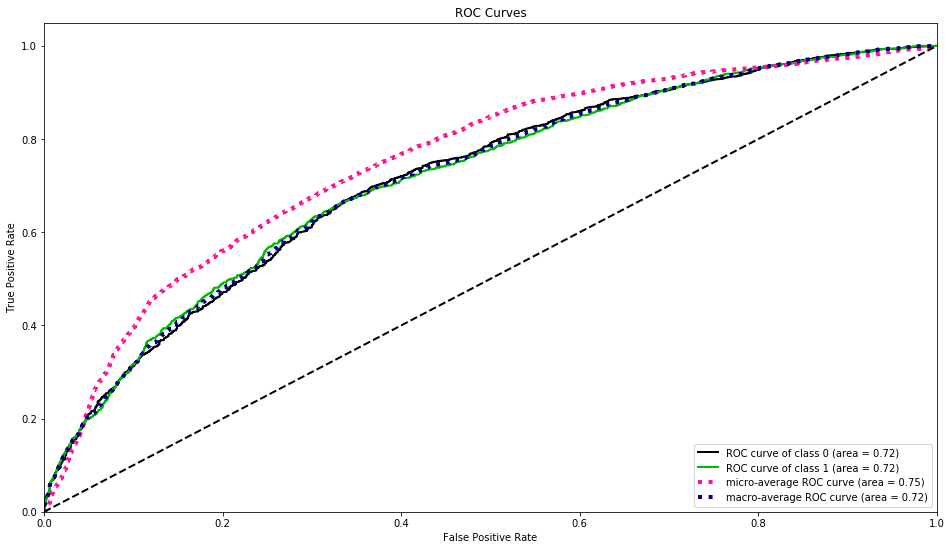

In [30]:
skplt.metrics.plot_roc(y_test, y_pred_proba)
plt.show()


We finally have a model that has good recall and the AUC is still 0.72 which is around the previous optimum found by other models that had bad recall.

## Serialize model

In [33]:
pickle.dump(model2, open("short_term_xgboost_v3.pickle.dat", "wb"))

## Feature Importance

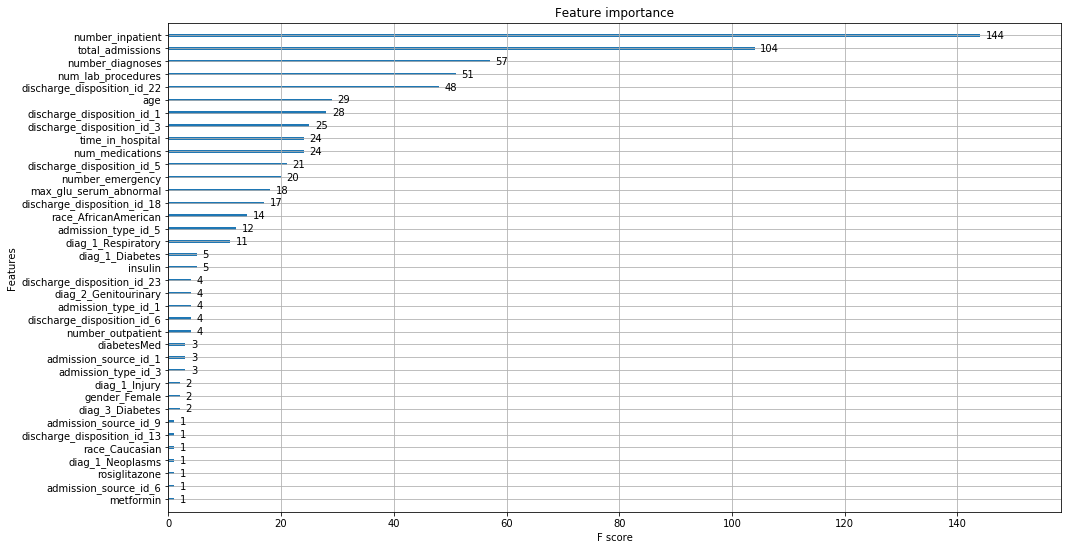

In [31]:
plt.rcParams["figure.figsize"] = [16,9]
plot_importance(best_model)
plt.show()

There are a lot of features here but we can limit the number of features because it appears that only the top few are important.

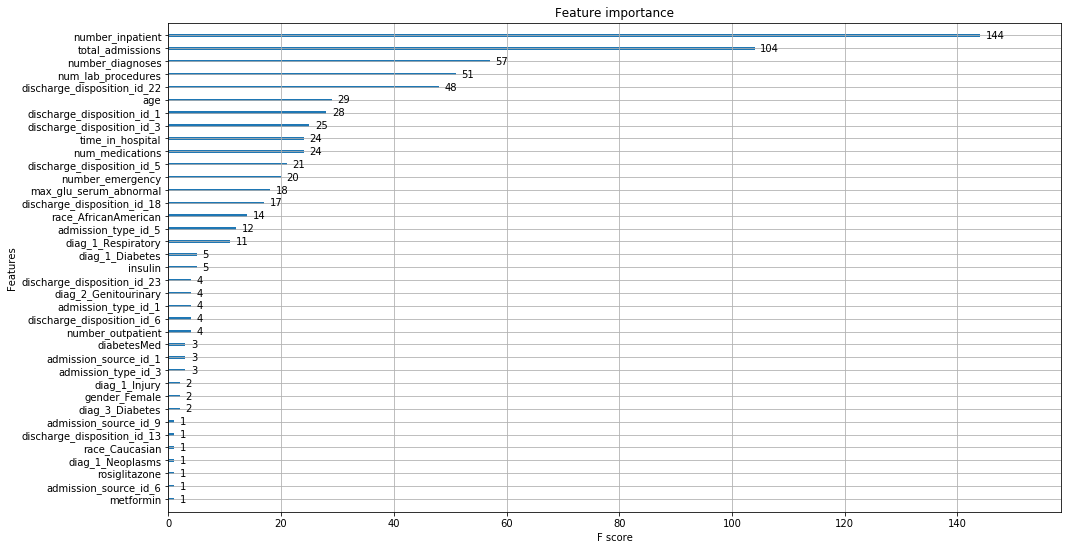

In [32]:
plot_importance(best_model, max_num_features=50)
plt.show()
